In [15]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as Function
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

# Load data

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [17]:
input_data=[]
target_data=[]

for _, (data,target) in enumerate(train_loader):
        data =data.view(-1,784)
        data=data.numpy()
        input_data.append(data)

In [18]:
full_input=np.array(input_data[0])
full_input=torch.Tensor(full_input)

for i in range(1,938):
    intermed=np.array(input_data[i])
    intermed=torch.Tensor(intermed)
    
    full_input=torch.cat((full_input, intermed),0)

# RBM

In [19]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=1000,
                 k=1):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_p(self,p):
        return Function.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = Function.sigmoid(Function.linear(v,self.W,self.h_bias))
        sample_h = self.sample_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = Function.sigmoid(Function.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_, h_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = Function.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

# Train

In [20]:
rbm = RBM()
train_op = optim.SGD(rbm.parameters(),0.1)

In [21]:
batch_size_=64

for epoch in range(10):
    loss_ = []
    reconstruction_error=0
    s=0
    for n in range(0, len(full_input)- batch_size_, batch_size_):
        sample_data=full_input[n:n+batch_size_]
        sample_data=Variable(sample_data)
        sample_data = sample_data.bernoulli()
        
        
        v,v1,h1 = rbm(sample_data)
        
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data[0])
        
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        reconstruction_error+=torch.mean(torch.abs(v-v1))
        s+=1
        
    print ('Epoch: ' + str(epoch+1) +  
           ' - reconstructions error:  ' + str(reconstruction_error.data.numpy()[0]/s) + 
           ' - free energy loss: ' + str(np.mean(loss_)))  

Epoch: 1 - reconstructions error:  0.0862144787767 - free energy loss: -0.704133480565
Epoch: 2 - reconstructions error:  0.0601227352179 - free energy loss: -3.88155792464
Epoch: 3 - reconstructions error:  0.054044851753 - free energy loss: -2.5956454445
Epoch: 4 - reconstructions error:  0.0506621353654 - free energy loss: -1.67604590938
Epoch: 5 - reconstructions error:  0.0485298661565 - free energy loss: -1.04325106202
Epoch: 6 - reconstructions error:  0.0469868475752 - free energy loss: -0.639758261698
Epoch: 7 - reconstructions error:  0.0458210402644 - free energy loss: -0.315118812064
Epoch: 8 - reconstructions error:  0.0449559345062 - free energy loss: -0.109836867423
Epoch: 9 - reconstructions error:  0.0442243553658 - free energy loss: 0.101519280335
Epoch: 10 - reconstructions error:  0.0436448959302 - free energy loss: 0.268009377137


# Testing

In [22]:
input_data=[]

for _, (data,target) in enumerate(test_loader):
        data =data.view(-1,784)
        data=data.numpy()
        input_data.append(data)

In [23]:
test_set=np.array(input_data[0])
test_set=torch.Tensor(test_set)

for i in range(1,157):
    intermed=np.array(input_data[i])
    intermed=torch.Tensor(intermed)
    
    test_set=torch.cat((test_set, intermed),0)      

In [36]:
import time
start_time = time.time()

output=[]
target_output=[]

test_loss = 0
s=0
for n in range(0,len(test_set)):
    sample_data=Variable(test_set)
    sample_data = sample_data[n:n+1]

    v,v1,h1 = rbm(sample_data)
    test_loss+=torch.mean(torch.abs(v-v1))
    s+=1
    
    loss = rbm.free_energy(v) - rbm.free_energy(v1)
    loss_.append(loss.data[0])
    
    output.append(v1)
    target_output.append(v)
    
    
print ('Reconstructions error:  ' + str(test_loss.data.numpy()[0]/s)+ 
          ' - free energy loss: ' + str(np.mean(loss_)))  
print("--- training time is %s seconds ---" % (time.time() - start_time))

Reconstructions error:  0.0498306915283 - free energy loss: 10.9363112575
--- training time is 21.960931062698364 seconds ---


# Visualising Results

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualise_and_save(file_name,image):
    npimage = np.transpose(image.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimage)
    plt.imsave(f,npimage)

In [60]:
target_pixels_=[]

for n in range(0, 10000):
    target_pixels_n=target_output[n][0].data.numpy()
    target_pixels_.append(target_pixels_n)
    
target_pixels_=np.array(target_pixels_)

t=torch.Tensor(target_pixels_)

t=t[0:32]

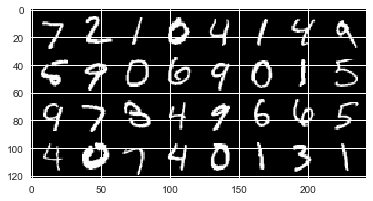

In [65]:
visualise_and_save("real",make_grid(t.view(32,1,28,28)))

In [84]:
output_array=[]

for n in range(0, 10000):
    output_n=output[n][0].data.numpy()
    output_array.append(output_n)
    
output_array=np.array(output_array)

n=torch.Tensor(output_array)

n=n[0:32]

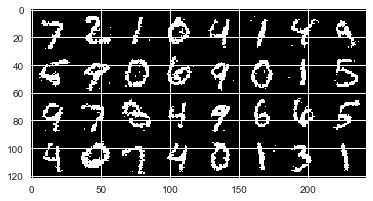

In [85]:
visualise_and_save("mean quantised",make_grid(n.view(32,1,28,28)))

# Compression of Model

In [31]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
#import pandas as pd


import seaborn as sns
sns.set(color_codes=True)

In [34]:
weights=rbm.W
weights=weights.data.numpy()


x=weights.reshape(784000)

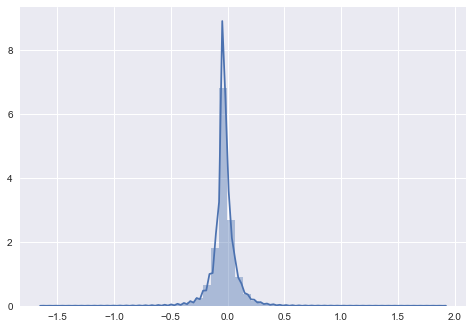

In [35]:
sns.distplot(x)


In [ ]:
savedweights=weights
x=savedweights.reshape(490000)

In [80]:
# Mean

positive=[]
negative=[]
for n in x:
    if n>0:
        positive.append(n)
    elif n<0:
        negative.append(n)

m=[]
for n in negative:
    if n>-0.5:
        m.append(n)

m=np.array(m)
print (np.median(m))



-0.0491131


In [47]:
# Prune


i = []

for w in x:
    if w < 0.03 and w > -0.03:
        w=0
        
    else:
        w=w
    i.append(w)

i=np.array(i).reshape(1000, 784)

w=torch.Tensor(i)


o=torch.nn.Parameter(w)
rbm.W=o

In [49]:
# quantise

q=[]

for w in x:
    if w > 0.15:
        w=float(1)
    elif w<-0.15:
        w=float(-1)
    else:
        w=float(0)
    q.append(w)
    
q=np.array(q).reshape(625, 784)
w=torch.Tensor(q)
w=torch.nn.Parameter(w)
rbm.W=w

Reconstructions error:  0.0501299255371 - free energy loss: 10.9081034913
--- training time is 23.83634090423584 seconds ---


In [86]:
# mean quantise

q=[]

for w in x:
    if w >= 0.3:
        w=float(1)
    elif w > 0.02 and w<0.3:
        w=float(0.07)
    elif w<=-0.3:
        w=float(-1)
    elif w<-0.02 and w>-0.3:
        w=float(-0.07)
    else:
        w=float(0)
    q.append(w)
    
q=np.array(q).reshape(1000, 784)
w=torch.Tensor(q)
w=torch.nn.Parameter(w)
rbm.W=w

In [87]:
import time
start_time = time.time()

output=[]
target_output=[]

test_loss = 0
s=0
for n in range(0,len(test_set)):
    sample_data=Variable(test_set)
    sample_data = sample_data[n:n+1]

    v,v1,h1 = rbm(sample_data)
    test_loss+=torch.mean(torch.abs(v-v1))
    s+=1
    
    loss = rbm.free_energy(v) - rbm.free_energy(v1)
    loss_.append(loss.data[0])
    
    output.append(v1)
    target_output.append(v)
    
    
print ('Reconstructions error:  ' + str(test_loss.data.numpy()[0]/s)+ 
          ' - free energy loss: ' + str(np.mean(loss_)))  
print("--- training time is %s seconds ---" % (time.time() - start_time))

Reconstructions error:  0.056010534668 - free energy loss: nan
--- training time is 21.73994207382202 seconds ---
